# Exploratory Data Analysis

This section will cover:

* initial exploratory analysis
* grammar and spelling correction 
* feature extraction with SpaCy 

In [4]:
%matplotlib inline

import numpy as np
import pandas as pd
import re
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from string import punctuation

#import language_check

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.externals import joblib
from sklearn.model_selection import train_test_split

import pyLDAvis
from pyLDAvis.sklearn import prepare

plt.style.use('seaborn-colorblind')

# Setup Pandas
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_colwidth', 100)

pyLDAvis.enable_notebook()
# plt.rcParams['figure.figsize'] = [8, 5]
plt.rcParams['figure.dpi']= 100

import warnings
warnings.simplefilter("ignore", DeprecationWarning)

In [3]:
!pip install pyLDAvis

     |████████████████████████████████| 1.6MB 2.4MB/s eta 0:00:01
     |████████████████████████████████| 552kB 4.2MB/s eta 0:00:01
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=100203 sha256=4691fcefde282cc4d50f53f5607fbab6135a28c212d67e9989505b1d041522a6
  Stored in directory: /Users/xuechunwang/Library/Caches/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
  Created wheel for funcy: filename=funcy-1.14-py2.py3-none-any.whl size=35130 sha256=4dc4fb6cb0132bf7edb77ba58667bf4b22f1a546b6c251f1a9132f26f509a883
  Stored in directory: /Users/xuechunwang/Library/Caches/pip/wheels/20/5a/d8/1d875df03deae6f178dfdf70238cca33f948ef8a6f5209f2eb
Successfully built pyLDAvis funcy


In [5]:
training_set  = pd.read_csv('training_set_rel3.tsv', sep='\t', encoding = "ISO-8859-1")\
            .rename(columns={'essay_set': 'topic', 'domain1_score': 'target_score', 'domain2_score': 'topic2_target'})
training_set.sample()

,essay_id,topic,essay,rater1_domain1,rater2_domain1,rater3_domain1,target_score,rater1_domain2,rater2_domain2,topic2_target,rater1_trait1,rater1_trait2,rater1_trait3,rater1_trait4,rater1_trait5,rater1_trait6,rater2_trait1,rater2_trait2,rater2_trait3,rater2_trait4,rater2_trait5,rater2_trait6,rater3_trait1,rater3_trait2,rater3_trait3,rater3_trait4,rater3_trait5,rater3_trait6
5719,9274,4,In the story I think the author concludes that paragraph with the story because Saeng is...,2,1,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
training_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12976 entries, 0 to 12975
Data columns (total 28 columns):
essay_id          12976 non-null int64
topic             12976 non-null int64
essay             12976 non-null object
rater1_domain1    12976 non-null int64
rater2_domain1    12976 non-null int64
rater3_domain1    128 non-null float64
target_score      12976 non-null int64
rater1_domain2    1800 non-null float64
rater2_domain2    1800 non-null float64
topic2_target     1800 non-null float64
rater1_trait1     2292 non-null float64
rater1_trait2     2292 non-null float64
rater1_trait3     2292 non-null float64
rater1_trait4     2292 non-null float64
rater1_trait5     723 non-null float64
rater1_trait6     723 non-null float64
rater2_trait1     2292 non-null float64
rater2_trait2     2292 non-null float64
rater2_trait3     2292 non-null float64
rater2_trait4     2292 non-null float64
rater2_trait5     723 non-null float64
rater2_trait6     723 non-null float64
rater3_trait1     128

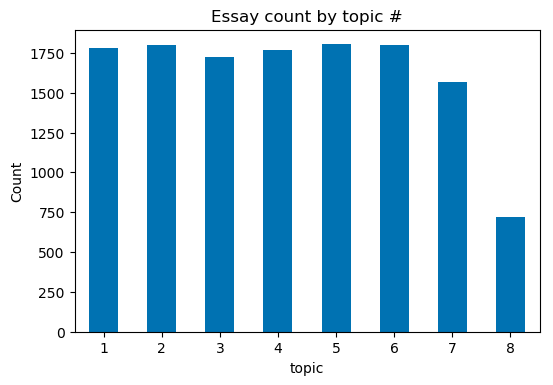

In [7]:
training_set.groupby('topic').agg('count').plot.bar(y='essay', rot=0, legend=False)
plt.title('Essay count by topic #')
plt.ylabel('Count')
plt.show()

Since topic 8 has the fewest essays and the most distinct scores, it might prove to be the most challenging topic to model.

In [8]:
# Count characters and words for each essay
training_set['word_count'] = training_set['essay'].str.strip().str.split().str.len()

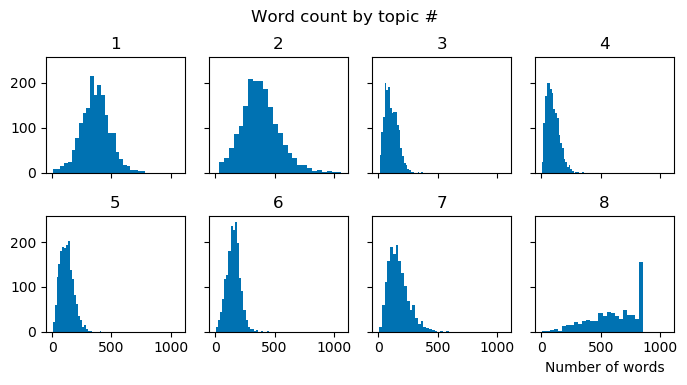

In [9]:
training_set.hist(column='word_count', by='topic', bins=25, sharey=True, sharex=True, layout=(2, 4), figsize=(7,4), rot=0) 
plt.suptitle('Word count by topic #')
plt.xlabel('Number of words')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [10]:
training_set.groupby(['topic'])['target_score'].agg(['min','max','count','nunique'])

,min,max,count,nunique
topic,,,,
1,2,12,1783,11
2,1,6,1800,6
3,0,3,1726,4
4,0,3,1770,4
5,0,4,1805,5
6,0,4,1800,5
7,2,24,1569,23
8,10,60,723,34


/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


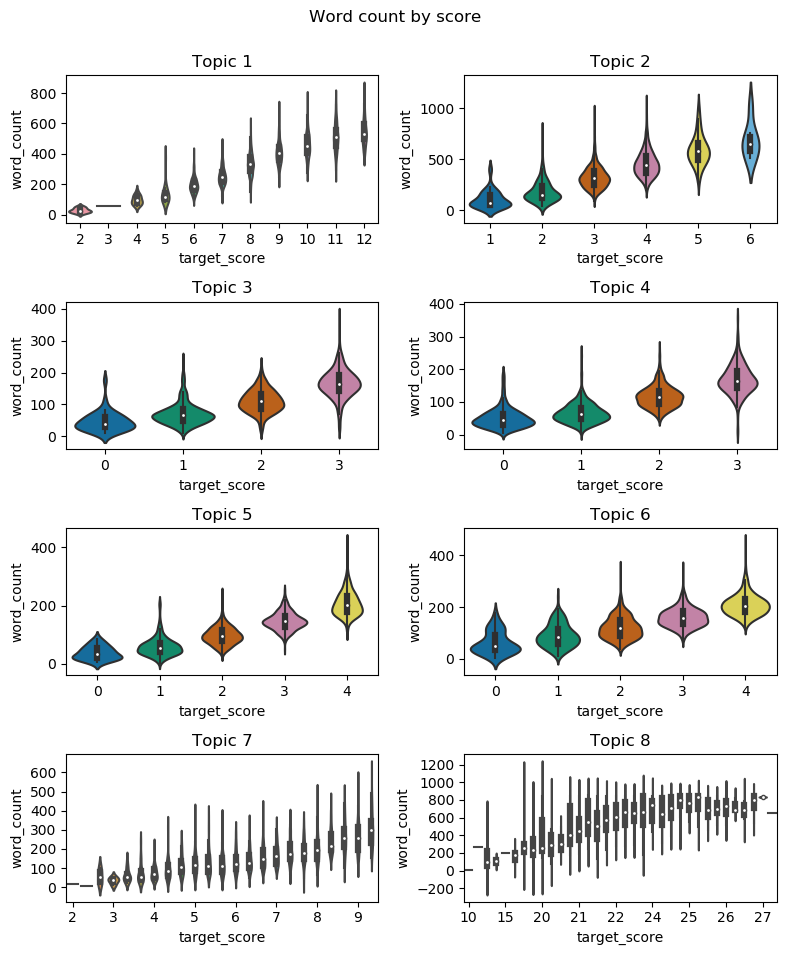

In [11]:
topic_number = 0
fig, ax = plt.subplots(4,2, figsize=(8,10))
for i in range(4):
    for j in range(2):
        topic_number += 1
        sns.violinplot(x='target_score', y='word_count', data=training_set[training_set['topic'] == topic_number], ax=ax[i,j])
        ax[i,j].set_title('Topic %i' % topic_number)
ax[3,0].locator_params(nbins=10)
ax[3,1].locator_params(nbins=10)
plt.suptitle('Word count by score')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

We can see a reasonable correlation between word count and score for all but topic 8 where the word count apparently reaches a maximum at the upper third of the scores.

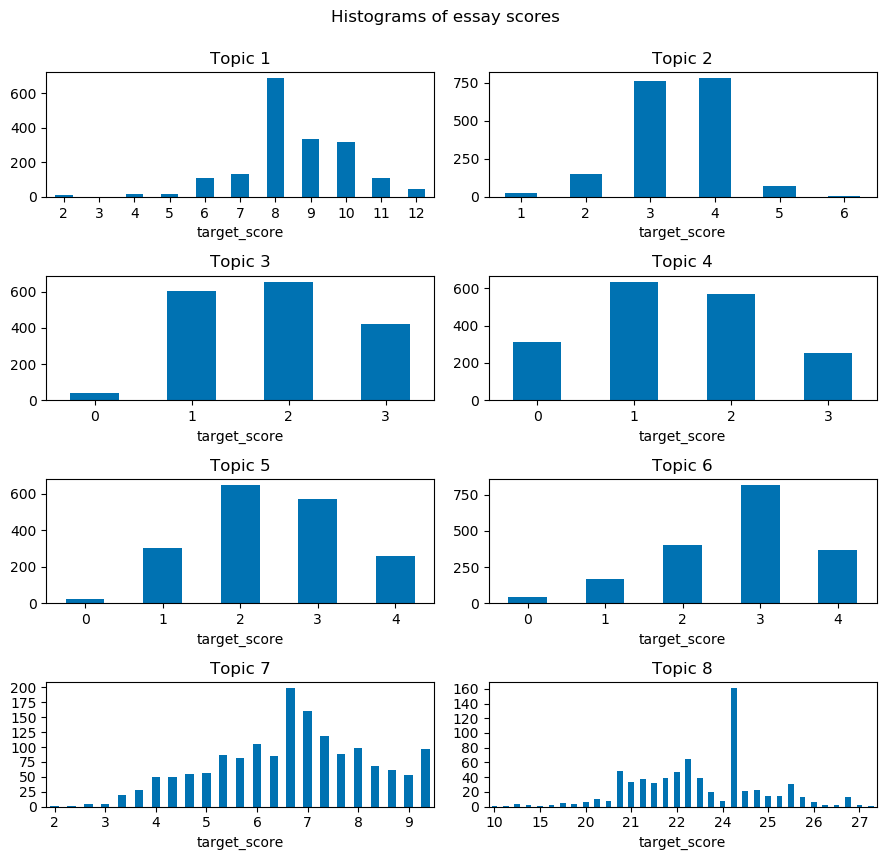

In [12]:
topic_number = 0
fig, ax = plt.subplots(4,2, figsize=(9,9), sharey=False)
for i in range(4):
    for j in range(2):
        topic_number += 1
        training_set[training_set['topic'] == topic_number]\
            .groupby('target_score')['essay_id']\
            .agg('count')\
            .plot.bar(ax=ax[i, j], rot=0)
        ax[i,j].set_title('Topic %i' % topic_number)
ax[3,0].locator_params(nbins=10)
ax[3,1].locator_params(nbins=10)
plt.suptitle('Histograms of essay scores')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Many scores are underrepresented. Classification could be difficult without rebalancing.

## Essay processing:

1. Language correction with languagetool (add number of corrections as feature)
2. Sentence tokenization with Spacy
3. Sentence count and length
4. Word tokenize with Spacy
5. Word token classification (punctuation, stop words and anonymized entities, pos, ent)
6. Document similarity (based on arbitrary high scoring essay for each topic)

## NLP with SpaCy

Although much of the analysis could be performed with other NLP packages, SpaCy was chosen due to its combination of speed and simplicity.

In [17]:
#training_set = pd.read_pickle('training_corr.pkl')

In [14]:
sents = []
tokens = []
lemma = []
pos = []
ner = []

stop_words = set(STOP_WORDS)
stop_words.update(punctuation) # remove it if you need punctuation 

nlp = spacy.load('en_core_web_sm')

t0 = datetime.now()

# suppress numpy warnings
np.warnings.filterwarnings('ignore')

for essay in nlp.pipe(training_set['essay'], batch_size=100, n_threads=3):
    if essay.is_parsed:
        tokens.append([e.text for e in essay])
        sents.append([sent.string.strip() for sent in essay.sents])
        pos.append([e.pos_ for e in essay])
        ner.append([e.text for e in essay.ents])
        lemma.append([n.lemma_ for n in essay])
    else:
        # We want to make sure that the lists of parsed results have the
        # same number of entries of the original Dataframe, so add some blanks in case the parse fails
        tokens.append(None)
        lemma.append(None)
        pos.append(None)
        sents.append(None)
        ner.append(None)

training_set['tokens'] = tokens
training_set['lemma'] = lemma
training_set['pos'] = pos
training_set['sents'] = sents
training_set['ner'] = ner

t1 = datetime.now()
print('Processing time: {}'.format(t1 - t0))

Processing time: 0:09:29.343316


In [15]:
training_set.to_pickle('training_spacy.pkl')

In [16]:
training_set = pd.read_pickle('training_spacy.pkl')

In [17]:
training_set[['tokens', 'pos', 'sents', 'ner']].head()

,tokens,pos,sents,ner
0,"[Dear, local, newspaper, ,, I, think, effects, computers, have, on, people, are, great, learning...","[ADJ, ADJ, NOUN, PUNCT, PRON, VERB, NOUN, NOUN, VERB, ADP, NOUN, VERB, ADJ, NOUN, NOUN, SYM, NOU...","[Dear local newspaper, I think effects computers have on people are great learning skills/affect...",[@DATE1]
1,"[Dear, @CAPS1, @CAPS2, ,, I, believe, that, using, computers, will, benefit, us, in, many, ways,...","[ADJ, PROPN, PUNCT, PUNCT, PRON, VERB, ADP, VERB, NOUN, VERB, VERB, PRON, ADP, ADJ, NOUN, ADP, V...","[Dear @CAPS1 @CAPS2, I believe that using computers will benefit us in many ways like talking an...","[millions, one, millions, @MONTH1, @LOCATION2, Million, one, non-stopp for hours, The other day,..."
2,"[Dear, ,, @CAPS1, @CAPS2, @CAPS3, More, and, more, people, use, computers, ,, but, not, everyone...","[ADJ, PUNCT, PROPN, PUNCT, PROPN, ADJ, CCONJ, ADJ, NOUN, VERB, NOUN, PUNCT, CCONJ, ADV, NOUN, VE...","[Dear, @CAPS1 @CAPS2 @CAPS3 More and more people use computers, but not everyone agrees that thi...","[today, one, @CAPS4, one, @MONTH1, thousand, @ORGANIZATION1]"
3,"[Dear, Local, Newspaper, ,, @CAPS1, I, have, found, that, many, experts, say, that, computers, d...","[ADJ, PROPN, PROPN, PUNCT, PROPN, PRON, VERB, VERB, ADP, ADJ, NOUN, VERB, ADP, NOUN, VERB, ADV, ...","[Dear Local Newspaper, @CAPS1, I have found that many experts say that computers do not benifit ...","[Dear Local Newspaper, @PERSON1, @PERSON2, @CAPS4, @LOCATION2, @PERCENT3, @LOCATION1, A+, Newspa..."
4,"[Dear, @LOCATION1, ,, I, know, having, computers, has, a, positive, effect, on, people, ., The, ...","[ADJ, ADP, PUNCT, PRON, VERB, VERB, NOUN, VERB, DET, ADJ, NOUN, ADP, NOUN, PUNCT, DET, NOUN, VER...","[Dear @LOCATION1, I know having computers has a positive effect on people., The computers connec...","[First, @NUM1 hours, one, Secondly, @LOCATION2, one, one]"


While the charts above are very similar to a confusion matrix, the ordering of the LDA derived topics (A,B,C,D) doesn't necessarily match the human-labeled topic ordering (0,1,2,3). Thus, the high percentages, shown here as deep blues, are not expected to be found along the diagonal. Instead the goal is to find topic distinction, indicated by a single dark square in each column, and model accuracy, indicated by identical color patterns between train and test data sets.

As seen above, there is some agreement between train and test data that essays with highest and lowest scores are distinct and assigned "Score A" and "Score B" respectively.  Overall, both topic distinction and model accuracy are rather poor. It is highly improbable this approach could be extended to any of the other topics due to the larger range of scores and class imbalance. 

Furthermore, repeated LDA runs show a lack of reproducability, which is a sign of poor distinction of topics. In summary, topic modelling, or more specifically using word frequencies and probabilities is not a useful tool to grade student essays. In the next notebook we'll continue with machine learning algorithms.